In [2]:
print("Test!")

Test!


In [2]:
# TODO: Aduth file somehow?
import ee
import numpy as np
import geopandas
import matplotlib.pyplot as plt

# from bqplot import pyplot as plt
# from ipyleaflet import *

# ee.Authenticate();
# ee.Initialize();

import geemap
import pandas as pd

from functools import partial

In [4]:
ee.Authenticate()

True

In [5]:
Map = geemap.Map(center=(40, -100), zoom=4)
Map.set_options(mapTypeId='SATELLITE');
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(ch…

In [6]:
#Pour Lhasa
shp_path = './Lhasa/Lhasa_RC_DGO2km_updated.shp';
lhasa_shp = geemap.shp_to_ee(shp_path);

In [5]:
#Pour Yamuna
shp_path = '/home/pierre/PycharmProjects/pythonProject/ENS/ee-water-extraction/example_data/Yamuna_segm_2km_UTF8_copy.shp';
yamuna_shp = geemap.shp_to_ee(shp_path);

In [7]:
def getCover(image, AOI, scale):
    totPixels = ee.Number(image.unmask(1).reduceRegion(
        reducer=ee.Reducer.count(),
        scale=SENTINEL_SCALE,
        geometry=AOI,
        maxPixels=1e13
    ).values().get(0));
    actPixels = ee.Number(image.reduceRegion(
        reducer=ee.Reducer.count(),
        scale=SENTINEL_SCALE,
        geometry=AOI,
        maxPixels=1e13
    ).values().get(0));
    percCover = actPixels.divide(totPixels).multiply(100).round();
    return image.set('percCover', percCover);

#=============================================================================== 
# Braaten-Cohen-Yang cloud detection 
# https://sentinel-hub.github.io/custom-scripts/sentinel-2/cby_cloud_detection/
#=============================================================================== 

def addNDGR(image):
    return image.addBands(**{
        'srcImg': image.normalizedDifference(['B3', 'B4']).rename('NDGR')
    });


def addIS_CLOUD(image):
    return image.addBands(image.expression('((Green / 10000 > 0.175 && NDGR > -0.015) || (Green / 10000 > 0.39))', {
        'Green': image.select('B3'),
        'NDGR' : image.select('NDGR'),
    }).rename('IS_CLOUD'));

def IS_CLOUD_TO_PROPERTY(AOI, image):
    return image.set(image.select('IS_CLOUD').reduceRegion(**{
        'reducer' : ee.Reducer.mean(),
        'scale' : SENTINEL_SCALE,
        'geometry' : AOI,
        'maxPixels' : 1e12
    }));

def addMNDWI(image):
    return image.addBands(srcImg=image.normalizedDifference(['B3','B11']).rename('MNDWI')); # B3=greenl B11=SWIR

def addIS_WATER_MNDWI(image):
    return image.addBands(image.expression('MNDWI >  0.0', {
        'MNDWI': image.select('MNDWI'),
    }).rename('IS_WATER_MNDWI'));

def IS_WATER_INDIC(INDIC, ImColl):
    return ImColl.select('IS_WATER_' + INDIC).map(lambda image: image.updateMask(image.neq(0)));

def process_polygon(shp, dgo=1, START_DATE='1988-04-06', END_DATE='1988-04-08'):
    filt = ee.Filter.inList('DGO_FID', [dgo]);
    AOI = shp.filter(filt);
    filtered_DGO = AOI;
    AOI_ID=f'middle_ID{1}';

    START = ee.Date(START_DATE);
    END = ee.Date(END_DATE);
    DAY_DIFF = ee.Date(END_DATE).difference(START, 'day');
    DAY_RANGE = ee.List.sequence(0,DAY_DIFF.subtract(1),1).map(lambda day: START.advance(day,'day'));

    CLOUD_PAL = ['gray', 'white'];
    NDWI_PAL = ['black','white','blue'];
    NDVI_PAL = ['black','white','green'];

    SENTINEL_FULL = ee.ImageCollection('COPERNICUS/S2_SR');

    SENTINEL = (SENTINEL_FULL
                .filterDate(START_DATE, END_DATE)
                .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER))
                .filterBounds(AOI));

    
    SENTINEL = SENTINEL.map(lambda image: getCover(image, AOI, SENTINEL_SCALE)); # CC AT THE DGO LEVEL!
    SENTINEL = SENTINEL.filterMetadata('percCover', 'greater_than', CLOUD_FILTER_2); # DEFAULT 98
    SENTINEL = SENTINEL.map(addMNDWI);

    SENTINEL = (SENTINEL
                .map(addNDGR).map(addIS_CLOUD)
                .map(partial(IS_CLOUD_TO_PROPERTY, AOI))
                .filterMetadata('IS_CLOUD', 'less_than', CLOUD_THRESHOLD / 100));
    
    SENTINEL = SENTINEL.map(addIS_WATER_MNDWI);

    IS_WATER_MNDWI = IS_WATER_INDIC('MNDWI', SENTINEL);
    return AOI, SENTINEL, IS_WATER_MNDWI;

MIN_PIX = 10; # // To filter small water polygons
CLOUD_FILTER = 80;
CLOUD_FILTER_2 = 98;
CLOUD_THRESHOLD = 5; # acceptable percentage of cloud above our AOI
SENTINEL_SCALE = 10;
SIMPLIFY_TOLERANCE_N = 2;

In [8]:
#Pour Lhasa
AOI, SENTINEL, IS_WATER_MNDWI = process_polygon(shp=lhasa_shp, dgo=1, START_DATE='2020-01-01', END_DATE='2020-05-30');

In [8]:
#Pour Yamuna
AOI, SENTINEL, IS_WATER_MNDWI = process_polygon(shp=yamuna_shp, dgo=1, START_DATE='2020-01-01', END_DATE='2020-05-30');

In [9]:
Map.addLayer(SENTINEL.first(), {"bands": ['B4', 'B3', 'B2'], "min": 0, "max": 2000}, 'RGB');

In [10]:
#Pour Lhasa
Map.addLayer(lhasa_shp, {}, 'Lhasa River SHP');
Map.addLayer(IS_WATER_MNDWI.first(), {'palette': 'Reds'}, 'water MNDWI', True);
Map.zoom = 11
Map.center_object(lhasa_shp);

In [10]:
#Pour Yamuna
Map.addLayer(yamuna_shp, {}, 'Yamuna River SHP');
Map.addLayer(IS_WATER_MNDWI.first(), {'palette': 'Reds'}, 'water MNDWI', True);
Map.zoom = 11
Map.center_object(yamuna_shp);

In [13]:
def VECTORIZE(AOI, image):
    DAY_VECTORS = image.reduceToVectors(**{
        "geometry" : AOI,
        "scale" : SENTINEL_SCALE,
        "eightConnected" : True,
        "maxPixels" : 1e12,
        "geometryType" : 'polygon'
    });
    return DAY_VECTORS.set('system:time_start',image.get('system:time_start'));

# Add area info to filter out isolated pixels
def ADDPROPS_FEAT(feature): 
    return feature.set({'AREA' : feature.area(SENTINEL_SCALE)});

def WRAP_COL(AOI, collection):
    collection = (ee.FeatureCollection(collection).map(ADDPROPS_FEAT)
        .filterMetadata('AREA', 'greater_than', MIN_PIX * SENTINEL_SCALE * SENTINEL_SCALE));
    
    time_start = collection.get('system:time_start');
    collection.map(lambda feature: feature.set({'system:time_start' : time_start}));
    geom = collection.geometry();
    geom_smooth = collection.geometry().simplify(**{'maxError' : SIMPLIFY_TOLERANCE_N*SENTINEL_SCALE});
    polygon = AOI.geometry(); #this is the polygon of the AOI/DGO
    polygon_smooth = AOI.geometry().simplify(**{'maxError' : SIMPLIFY_TOLERANCE_N*SENTINEL_SCALE})

    return ee.Feature(geom, {
        'TOTAL_PERIM' : geom.perimeter(SENTINEL_SCALE),
        'AREA' : geom.area(SENTINEL_SCALE),
        'TOTAL_PERIM_SMOOTH' : geom_smooth.perimeter(SENTINEL_SCALE),
        'AREA_SMOOTH' : geom_smooth.area(SENTINEL_SCALE),
        'AREA_POLYGON' : polygon_smooth.area(SENTINEL_SCALE), # this is the polygon of the AOI/DGO
        'SENSING_TIME' : collection.get('system:time_start')
    });

def WATER_VEC(AOI, ImColl):
    WVEC = ImColl.map(partial(VECTORIZE, AOI));
    return ee.FeatureCollection(WVEC.map(partial(WRAP_COL, AOI)));


import os
RIVER_PROPERTIES = [];
CLOUD_FILTER = 100;
CLOUD_FILTER_2 = 98; # Default 98

###########################################################################################
###########################################################################################
###########################################################################################
FILE_NAME = "Lhasa/Lhasa_Sentinel_Data-CC-80.csv";
#FILE_NAME = "Yamuna/Yamuna_Sentinel_Data-CC-80.csv";

# TODO: Read DGO Count from shp 

for i in range(1, 78):
    # TODO: Print using ipython notify (progress bar...)    
    RIVER_PROPERTIES = [];
    print("DGO:", i, "/", 77);
    
###########################################################################################
###########################################################################################
###########################################################################################
    AOI, SENTINEL, IS_WATER_MNDWI = process_polygon(shp=lhasa_shp, dgo=i, START_DATE='1980-01-01', END_DATE='2100-01-01');
    #AOI, SENTINEL, IS_WATER_MNDWI = process_polygon(shp=yamuna_shp, dgo=i, START_DATE='1980-01-01', END_DATE='2100-01-01');
    
    ISWV_MNDWI = WATER_VEC(AOI, IS_WATER_MNDWI);
    info = ISWV_MNDWI.getInfo(); # PROCESS AND PULL RESULT
    property_list = map(lambda x: {
            "ID": i,
            "Tile_ID": x['id'],
            **x['properties']
        }, info['features']);
    # Map over properties (calculate Braiding Index e.t.c.)
    RIVER_PROPERTIES += list(property_list);
    if(os.path.exists(FILE_NAME)):
        df = pd.read_csv(FILE_NAME, index_col=0);
        df = pd.concat([df, pd.DataFrame(RIVER_PROPERTIES)]);
    else:
        df = pd.DataFrame(RIVER_PROPERTIES);
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')];
    df.to_csv(FILE_NAME);    
print("Done!");

DGO: 1 / 77
DGO: 2 / 77
DGO: 3 / 77
DGO: 4 / 77
DGO: 5 / 77
DGO: 6 / 77
DGO: 7 / 77
DGO: 8 / 77
DGO: 9 / 77
DGO: 10 / 77
DGO: 11 / 77
DGO: 12 / 77
DGO: 13 / 77
DGO: 14 / 77
DGO: 15 / 77
DGO: 16 / 77
DGO: 17 / 77
DGO: 18 / 77
DGO: 19 / 77
DGO: 20 / 77
DGO: 21 / 77
DGO: 22 / 77
DGO: 23 / 77
DGO: 24 / 77
DGO: 25 / 77
DGO: 26 / 77
DGO: 27 / 77


KeyboardInterrupt: 

In [ ]:
collection = ee.ImageCollection('COPERNICUS/S2_SR').filterBounds(lhasa_shp);
geemap.ee_export_image_collection(collection, out_dir="./out_dir/")
# geemap.ee_export_image(image, filename='test.tif', scale=90, file_per_band=True)

In [21]:
#Pour Lhasa
df = pd.read_csv("./Lhasa/Lhasa_Sentinel_Data-CC-80.csv")
df['BRAIDING_INDEX'] = (df['TOTAL_PERIM_SMOOTH']/2)/2000; # Calculate braiding index
df.to_csv("./Lhasa/Lhasa_Sentinel_Data-CC-80.csv");

In [13]:
#Pour Yamuna
df = pd.read_csv("./Yamuna/Yamuna_Sentinel_Data-CC-80.csv")
df['BRAIDING_INDEX'] = (df['TOTAL_PERIM_SMOOTH']/2)/2000; # Calculate braiding index
df.to_csv("./Yamuna/Yamuna_Sentinel_Data-CC-80.csv");

In [42]:
df = pd.read_csv("./Lhasa/Lhasa_Sentinel_Data-CC-80.csv")

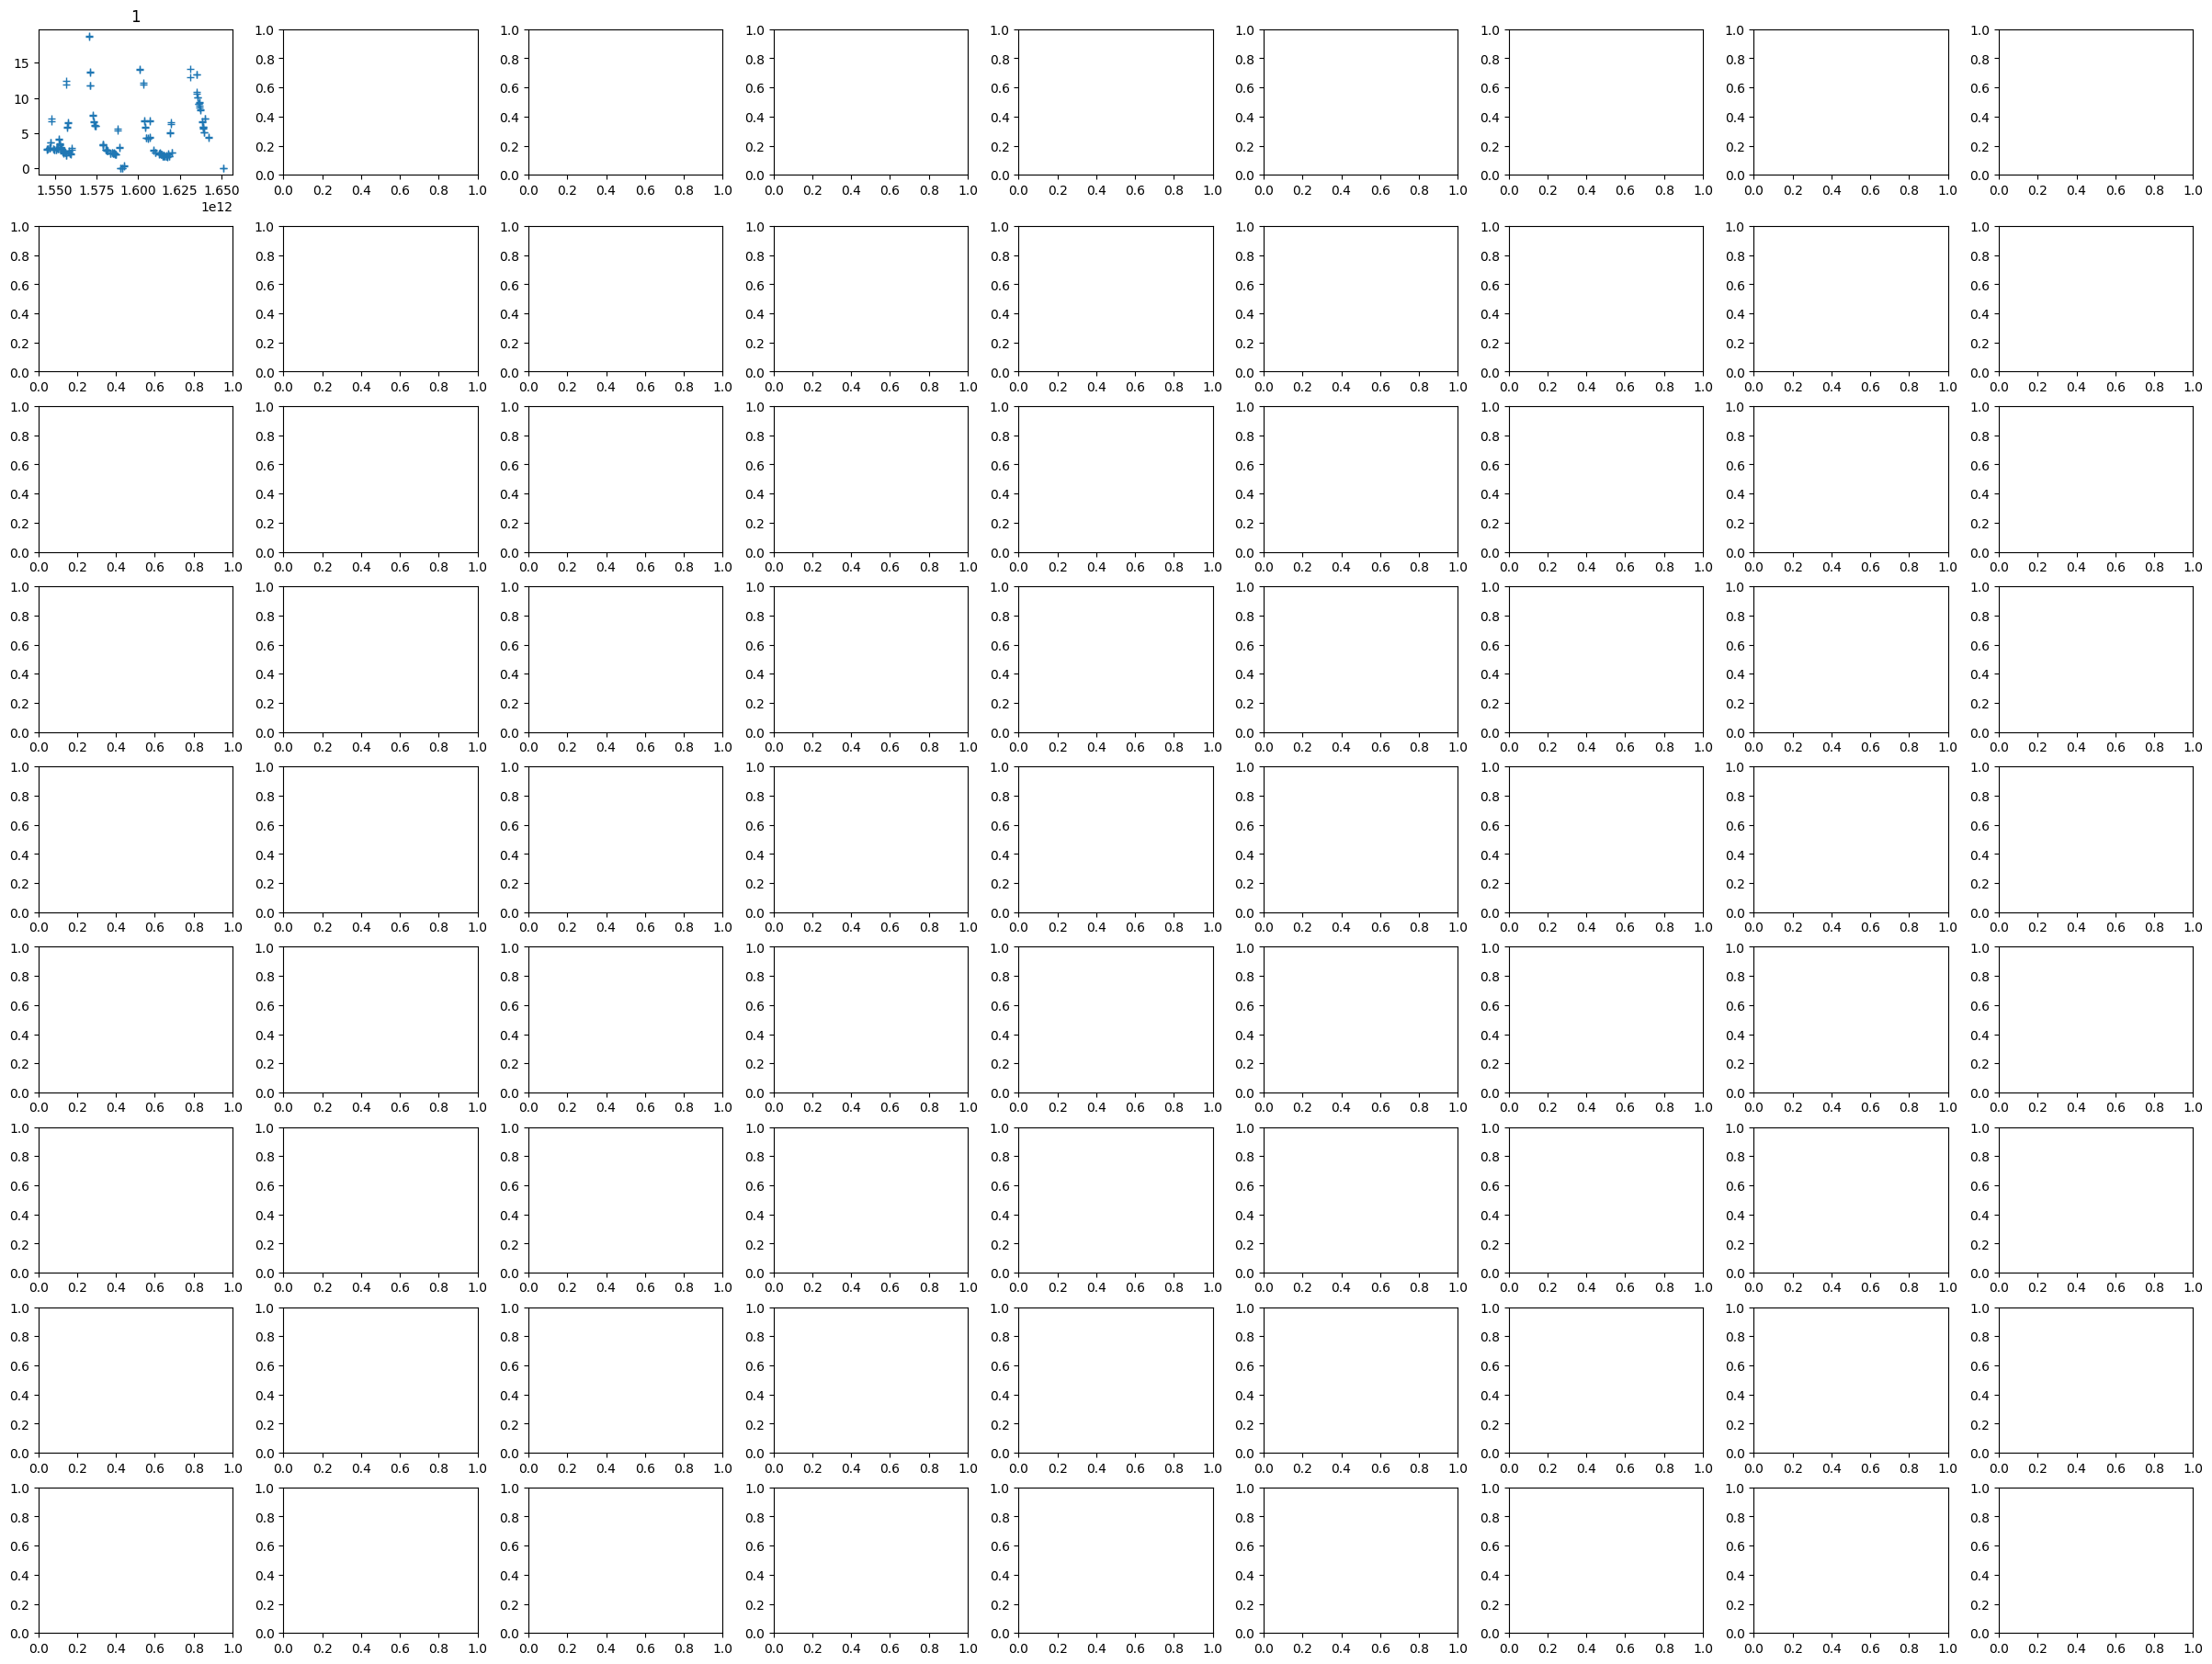

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [7]:
df_c = df.copy();

fig, axs = plt.subplots(9, 9, figsize=(24, 18), constrained_layout=True);
axs = axs.flatten();
for k, v in enumerate(range(1, 21)):
    df_d = df_c[df_c["ID"] == v];
    axs[k].set_title(v);
    axs[k].plot(df_d["SENSING_TIME"], df_d["BRAIDING_INDEX"], '+');

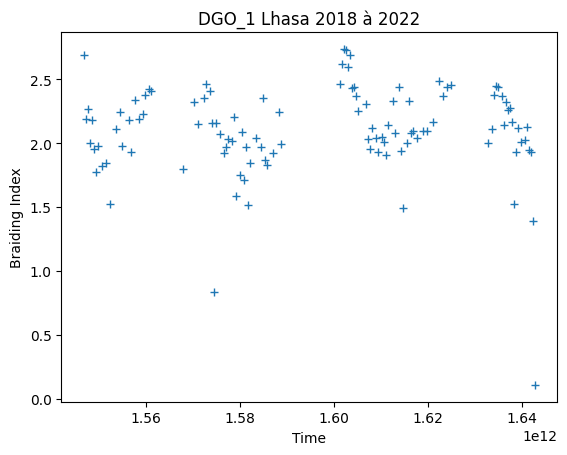

In [44]:
x_positions = np.linspace(0,1.64*10**12,5)
time = ["2018/12/22","2019/01/16","2020/04/25","2021/11/20","2022/04/20"]

df_c = df.copy();
df_d = df_c[df_c["ID"] == 1]

plt.figure()
plt.title("DGO_1 Lhasa 2018 à 2022")
plt.xlabel('Time')
#plt.xticks(x_positions, time, rotation=45)
plt.ylabel('Braiding Index')
plt.plot(df_d["SENSING_TIME"], df_d["BRAIDING_INDEX"], '+')
plt.show()

#path = '/home/pierre/Desktop/ENS/Réunion/Nelly/Mardi 23_01_2023/images/Yamuna/'
#plt.savefig(path + '/Yamuna_DGO 1.jpg')


In [32]:
max(df_d["SENSING_TIME"])

1651295489968

In [ ]:
# For call:
# Maybe try to get things working for Nelly...
# Python 3.10: https://github.com/google/earthengine-api/issues/181
# Python 3.9: Works
# Modules:
# numpy, pandas, matplotlib
# For Windows: pipwin gdal, fiona
# geemap, geopandas, ee
# TODO List:
# Fix laptop (DONE)
# Fix ownCloud (DONE)
# Email Eric about structure/limits of M1 Report (DONE) [reponse]


# Barbara:
# Look into making algorithm faster (doing all 78 in one pass?) [Currently it takes 1H to run...]
    # MAYBE I can run multiple .info() in seperate threads(??) (does google allow multiple requests like this?)
    # Cannot map over DGOs in a shape in a single command...
    # PERHAPS modify process_polygon (make it general) move it out of the loop!
    # Do process_polygon on ALL DGOs first - we can REUSE the same water map accordingly
    # Remove coordinates from object before sending it to clientside
# Try to make mosaic to avoid overlapping values. (Look at google earth api)
# https://developers.google.com/earth-engine/guides/ic_composite_mosaic

# Run again to extract SENTINEL data (from high-res sattelites)
  # REF: Barbara's email
# [Comparison between Sentinel & Landsat Data]
# Support for downloading tiles from meta information --> to use for GIS fieldwork

# Nelly/Patrice:
# Document installation procedure
# Reorganise repository 
# Write README.md

# For Monday:
# - extract the 4 channel images for the 200 timeslots and share them with me [finer scale analysis?]
# - extracted cvs. + processed data with l1 optimisation method for 3 differet level of cloud threshold
